In [1]:
import sys
sys.path.append('bulkfood/')

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

def draw_figure(num, **kwargs):
    
    settings = {
        'right': 2,
        'top': 1.5,
    }
    for key, val in kwargs.items():
        settings[key] = val
    
    path = 'figure/fig21_{}.png'.format(num)
    img = imageio.imread(path)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    ax.axis('off')
    fig.subplots_adjust(**settings)

# Chapter 21. 클래스 메타 프로그래밍

## 21.1 클래스 팩토리

### 예제 21.1

* 매우 간단

In [2]:
class Dog:
    def __init__(self, name, weight, owner):
        self.name = name
        self.weight = weight
        self.owner = owner

In [3]:
rex = Dog('Rex', 30, 'Bob')

* 그러나 맘에 안듬 (필드명 중복)
* 출력 포맷도 심각함 (repr)

In [4]:
print(rex)

* named tuple처럼 바꿔보자

In [5]:
from collections import namedtuple

Dog = namedtuple('Dog', ['name', 'weight', 'owner'])
rex = Dog('Rex', 30, 'Bob')
print(rex)

Dog(name='Rex', weight=30, owner='Bob')


### 예제  21-2

In [6]:
def record_factory(cls_name, field_names):
    try:
        field_names = field_names.replace(',', ' ').split()
    except AttributeError:
        pass
    field_names = tuple(field_names)
    
    def __init__(self, *args, **kwargs):
        attrs = dict(zip(self.__slots__, args))
        attrs.update(kwargs)
        for name, value in attrs.items():
            setattr(self, name, value)
            
    def __iter__(self):
        for name in self.__slots__:
            yield getattr(self, name)
            
    def __repr__(self):
        values = ', '.join('{}={!r}'.format(*i) for i in zip(self.__slots__, self))
        return '{}({})'.format(self.__class__.__name__, values)
    
    cls_attrs = dict(
        __slots__ = field_names,
        __init__ = __init__,
        __iter__ = __iter__,
        __repr__ = __repr__
    )
    
    return type(cls_name, (object,), cls_attrs)

In [7]:
Dog = record_factory('Dog', 'name weight owner')

In [8]:
rex = Dog('Rex', 30, 'Bob')

* 멋지게 출력

In [9]:
print(rex)

Dog(name='Rex', weight=30, owner='Bob')


In [10]:
print("{2}'s dog weight {1}kg".format(*rex))

Bob's dog weight 30kg


In [11]:
rex.weight = 32

In [12]:
print(rex)

Dog(name='Rex', weight=32, owner='Bob')


In [13]:
Dog.__mro__

(__main__.Dog, object)

#### cf. type
* type은 사실 클래스임 (새로운 클래스를 생성)
``` python
MyClass = type('MyClass', (MySuperClass, MyMixin), {'x': 42, 'x2': lambda self: self.x * 2})
```

* 아래와 동일
``` python
class MyClass(MySuperClass, MyMixin):
    x = 42
    
    def x2(self):
        return self.x * 2
```

* 클래스를 동적으로 생성

* namedtuple은 다른 방식 사용
    - \_class\_template과 namedtuple() 함수가 \_class\_template.format()을 호출해서 빈 칸을 채움
    - 그리고 나서 exec() 내장 함수로 생성된 소스 코드 문자열을 평가
    - \_\_asdict\_\_ 등의 method도 구현함
    - **직렬화(serialize) 가능** (pickle, dump ,load, $\cdots$)
    - **type은 직렬화 안됨**
    - 궁금하면 아래 참조  
    https://svn.python.org/projects/python/trunk/Lib/collections.py
    
* **python 메타프로그래밍에서 exec(), eval()은 가급적 피하는게 좋음**
    - 신뢰할 수 없는 곳에서 가져온 문자열 전달하면 심각한 문제 생길수도

``` python
type(name of the class, 
     tuple of the parent class (for inheritance, can be empty), 
     dictionary containing attributes names and values)
```

## 21.2 디스크립터를 커스터마이즈하기 위한 클래스 데커레이터

### 예제 21-3

In [14]:
import model_v6 as model

### 예제 21-4
``` python
def entity(cls):  # <1>
    for key, attr in cls.__dict__.items():  # <2>
        if isinstance(attr, Validated):  # <3>
            type_name = type(attr).__name__
            attr.storage_name = '_{}#{}'.format(type_name, key)  # <4>
    return cls  # <5>
```

1. 클래스 인수로 받음
2. 클래스 속성 담은 딕셔너리에 대해 반복
3. 속성이 Validated (model에 정의) 디스크립터면
4. 디스크립터 클래스명과 관리 대상 속성명 사용하기 위해 storage name 설정 (예: _Nonblack#description)
5. 변경된 클래스 반환

In [15]:
@model.entity
class LineItem:
    description = model.NonBlank()
    weight = model.Quantity()
    price = model.Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price

### 예제 21-5

In [16]:
raisins = LineItem('Golden raisins', 10, 6.95)

In [17]:
print(dir(raisins)[:3])

['_NonBlank#description', '_Quantity#price', '_Quantity#weight']


In [18]:
print(LineItem.description.storage_name)

_NonBlank#description


In [19]:
print(raisins.description)

Golden raisins


In [20]:
print(getattr(raisins, '_NonBlank#description'))

Golden raisins


## 21.3 임포트 타임과 런타임

### 예제 21-7 evalsupport.py

``` python
print('<[100]> evalsupport module start') # <1> import evaltime

def deco_alpha(cls):
    print('<[200]> deco_alpha') # <8> import evaltime

    def inner_1(self):
        print('<[300]> deco_alpha:inner_1')

    cls.method_y = inner_1
    return cls


class MetaAleph(type):
    print('<[400]> MetaAleph body') # <2> import evaltime

    def __init__(cls, name, bases, dic):
        print('<[500]> MetaAleph.__init__')

        def inner_2(self):
            print('<[600]> MetaAleph.__init__:inner_2')

        cls.method_z = inner_2


print('<[700]> evalsupport module end') # <3> import evaltime
```

### 예제 21-6 evaltime.py

``` python
from evalsupport import deco_alpha

print('<[1]> evaltime module start') # <4> import evaltime


class ClassOne():
    print('<[2]> ClassOne body') # <5> import evaltime

    def __init__(self):
        print('<[3]> ClassOne.__init__') # <11>

    def __del__(self):
        print('<[4]> ClassOne.__del__') # <18> 프로그램 끝날때 가비지 컬렉트됨

    def method_x(self):
        print('<[5]> ClassOne.method_x') # <12>

    class ClassTwo(object): # <6> import evaltime (내포된 클래스도 실행)
        print('<[6]> ClassTwo body')


@deco_alpha
class ClassThree():
    print('<[7]> ClassThree body') # <7> import evaltime (본체 평가 후 데커레이터 실행)

    def method_y(self):
        print('<[8]> ClassThree.method_y')


class ClassFour(ClassThree):
    print('<[9]> ClassFour body') # <9> import evaltime

    def method_y(self):
        print('<[10]> ClassFour.method_y')


if __name__ == '__main__':
    print('<[11]> ClassOne tests', 30 * '.') # <10>
    one = ClassOne()
    one.method_x()
    print('<[12]> ClassThree tests', 30 * '.') # <13>
    three = ClassThree()
    three.method_y() # <14>
    print('<[13]> ClassFour tests', 30 * '.') # <15>
    four = ClassFour()
    four.method_y() # <16> @deco_alpha는 ClassFoure에는 전혀 영향을 주지 않음


print('<[14]> evaltime module end') # <17> import evaltime
```

### 예제 21-8
* 인터프리터는 임포트된 모듈(evaltime)과 이 모듈이 임포트하는 모듈(evalsupport)에 들어 있는 모든 클래스 실행
* 데커레이터 실행 전에 장식된 클래스 본체를 먼저 평가
* 사용자 정의 함수나 메서드나 중에서는 **deco_alpha()**만 유일하게 실행

In [21]:
! python -c "import evaltime"

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime module start
<[2]> ClassOne body
<[6]> ClassTwo body
<[7]> ClassThree body
<[200]> deco_alpha
<[9]> ClassFour body
<[14]> evaltime module end


### 예제 21-9
* class attribute 실행
* 전역 변수 one에 바인딩된 ClassOne은 프로그램 끝날때 가비지 컬렉트됨
* ClassFour에서 super()를 이용해 ClassThree.method_y()를 실행하면 inner_1()이 실행
* **데커레이터로 클래스 계층구조 전체를 커스터마이징 할수는 없을까?**

In [22]:
! python evaltime.py

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime module start
<[2]> ClassOne body
<[6]> ClassTwo body
<[7]> ClassThree body
<[200]> deco_alpha
<[9]> ClassFour body
<[11]> ClassOne tests ..............................
<[3]> ClassOne.__init__
<[5]> ClassOne.method_x
<[12]> ClassThree tests ..............................
<[300]> deco_alpha:inner_1
<[13]> ClassFour tests ..............................
<[10]> ClassFour.method_y
<[14]> evaltime module end
<[4]> ClassOne.__del__


## 21.4 메타 클래스 기본 지식
* 일종의 클래스 팩토리
* record_factory()와 같은 함수 대신 클래스로 만들어지는 차이가 있음
* 파이썬 클래스(객체)는 기본적으로 type의 객체임
* type은 대부분 내장 클래스와 사용자 정의 클래스에 대한 메타클래스임

In [23]:
print('spam'.__class__)

<class 'str'>


In [24]:
print(str.__class__)

<class 'type'>


In [25]:
from bulkfood_v6 import LineItem

In [26]:
print(LineItem.__class__)

<class 'type'>


* 무한회귀 방지

In [27]:
print(type.__class__)

<class 'type'>


* **str, LineItem이 type을 상속하는게 아니라 모두 type의 객체임**
* 이들 모두는 object의 서브클래스임
* type은 object의 하위 클래스, object는 type의 객체

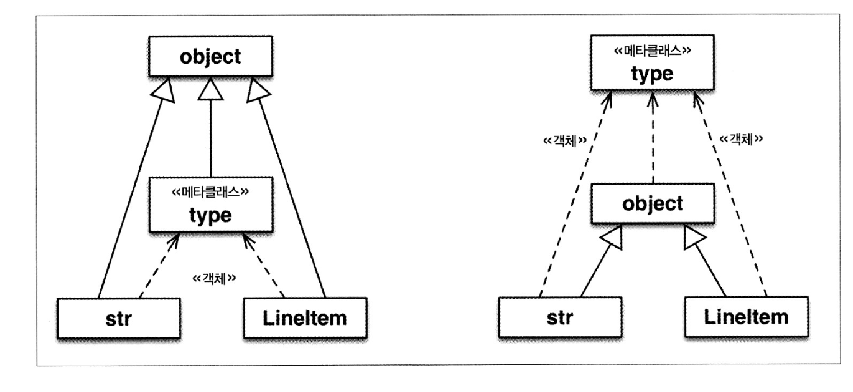

In [28]:
draw_figure(2)

In [29]:
import collections

In [30]:
print(collections.Iterable.__class__)

<class 'abc.ABCMeta'>


In [31]:
import abc

In [32]:
print(abc.ABCMeta.__class__)

<class 'type'>


* method resolution order

In [33]:
print(abc.ABCMeta.__mro__)

(<class 'abc.ABCMeta'>, <class 'type'>, <class 'object'>)


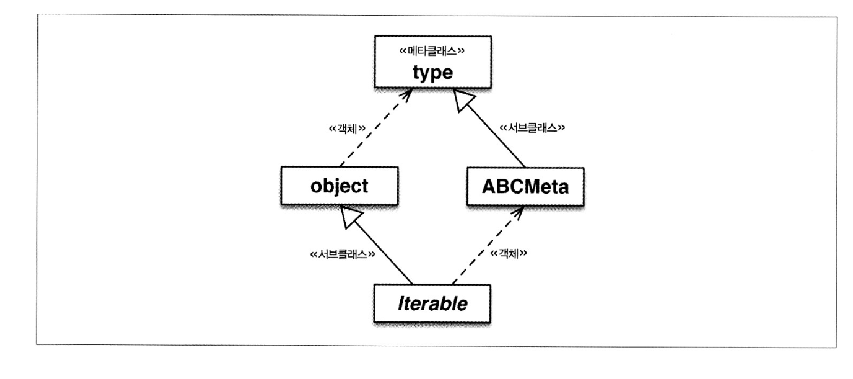

In [34]:
draw_figure(3)

## 21.4.1 메타 클래스 평가 시점

### 예제 21-10
### evalsupport
``` python
print('<[100]> evalsupport module start') # <1> import evaltime_meta

def deco_alpha(cls):
    print('<[200]> deco_alpha') # <6> import evaltime_meta

    def inner_1(self):
        print('<[300]> deco_alpha:inner_1')

    cls.method_y = inner_1
    return cls


class MetaAleph(type):
    print('<[400]> MetaAleph body') # <2> import evaltime_meta

    def __init__(cls, name, bases, dic):
        print('<[500]> MetaAleph.__init__') # <9>, <11> import evaltime_meta

        def inner_2(self):
            print('<[600]> MetaAleph.__init__:inner_2')

        cls.method_z = inner_2


print('<[700]> evalsupport module end') # <3> import evaltime_meta
```
### evaltime_meta
``` python
from evalsupport import deco_alpha
from evalsupport import MetaAleph

print('<[1]> evaltime_meta module start') # <4> import evaltime_meta


@deco_alpha
class ClassThree():
    print('<[2]> ClassThree body') # <5> import evaltime_meta

    def method_y(self):
        print('<[3]> ClassThree.method_y')


class ClassFour(ClassThree):
    print('<[4]> ClassFour body') # <7> import evaltime_meta

    def method_y(self):
        print('<[5]> ClassFour.method_y')


class ClassFive(metaclass=MetaAleph):
    print('<[6]> ClassFive body') # <8> import evaltime_meta

    def __init__(self):
        print('<[7]> ClassFive.__init__')

    def method_z(self):
        print('<[8]> ClassFive.method_y')


class ClassSix(ClassFive):
    print('<[9]> ClassSix body') # <10> import evaltime_meta

    def method_z(self):
        print('<[10]> ClassSix.method_y')


if __name__ == '__main__':
    print('<[11]> ClassThree tests', 30 * '.')
    three = ClassThree()
    three.method_y()
    print('<[12]> ClassFour tests', 30 * '.')
    four = ClassFour()
    four.method_y()
    print('<[13]> ClassFive tests', 30 * '.')
    five = ClassFive()
    five.method_z()
    print('<[14]> ClassSix tests', 30 * '.')
    six = ClassSix()
    six.method_z()

print('<[15]> evaltime_meta module end') # <12> import evaltime_meta

```

### 예제 21-11 
* python 인터프리터는 ClassFive 본체 평가하는 과정에서 type()대신 MetaAleph()를 호출
* MetaAleph.\_\_init\_\_은 ClassFive, ClassSix를 모두 초기화함!
* MetaAleph의 \_\_init\_\_은 네 개의 인수를 받음
___
    - cls  
___
    - name
    - bases
    - dic
___

* MetaAleph의 \_\_init\_\_() 에서 첫 번째 인수 이름이 self 대신 cls (관례적)
* 현재 생성하고 있는 것이 클래스임을 명시
    - MetaAleph.\_\_init\_\_(cls, $\cdots$)
        - cls: ClassFive, ClassSix(ClassFive)
    - inner_2(self)의 self는 현재 생성하고 있는 객체(ClassFive)를 가리킴

In [35]:
! python -c "import evaltime_meta"

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime_meta module start
<[2]> ClassThree body
<[200]> deco_alpha
<[4]> ClassFour body
<[6]> ClassFive body
<[500]> MetaAleph.__init__
<[9]> ClassSix body
<[500]> MetaAleph.__init__
<[15]> evaltime_meta module end


### 예제 21-13
* `<[600]> MetaAleph.__init__:inner_2`:
    - ClassSix는 MetaAleph를 직접 참조하지 않지마 영향을 받음
    - ClassFive를 상속하므로 ClassSix도 MetaAleph의 객체가 되어 MetaAleph.\_\_init\_\_()으로 초기화 됨

In [36]:
! python evaltime_meta.py

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime_meta module start
<[2]> ClassThree body
<[200]> deco_alpha
<[4]> ClassFour body
<[6]> ClassFive body
<[500]> MetaAleph.__init__
<[9]> ClassSix body
<[500]> MetaAleph.__init__
<[11]> ClassThree tests ..............................
<[300]> deco_alpha:inner_1
<[12]> ClassFour tests ..............................
<[5]> ClassFour.method_y
<[13]> ClassFive tests ..............................
<[7]> ClassFive.__init__
<[600]> MetaAleph.__init__:inner_2
<[14]> ClassSix tests ..............................
<[7]> ClassFive.__init__
<[600]> MetaAleph.__init__:inner_2
<[15]> evaltime_meta module end


## 21.5 디스크립터를 커스터마이즈하기 위한 클래스

### 예제 21-15 model_v7.py

``` python
import abc


class AutoStorage:
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self
        else:
            return getattr(instance, self.storage_name)

    def __set__(self, instance, value):
        setattr(instance, self.storage_name, value)


class Validated(abc.ABC, AutoStorage):

    def __set__(self, instance, value):
        value = self.validate(instance, value)
        super().__set__(instance, value)

    @abc.abstractmethod
    def validate(self, instance, value):
        """return validated value or raise ValueError"""


class Quantity(Validated):
    """a number greater than zero"""

    def validate(self, instance, value):
        if value <= 0:
            raise ValueError('value must be > 0')
        return value


class NonBlank(Validated):
    """a string with at least one non-space character"""

    def validate(self, instance, value):
        value = value.strip()
        if len(value) == 0:
            raise ValueError('value cannot be empty or blank')
        return value

# BEGIN MODEL_V7
class EntityMeta(type):
    """Metaclass for business entities with validated fields"""

    def __init__(cls, name, bases, attr_dict):
        super().__init__(name, bases, attr_dict)  # <1> 슈퍼클래스(여기선 type)의 __init__() 메서드 호출
        for key, attr in attr_dict.items():  # <2> 예제 21-4의 @entity와 동일한 기능 (뒤에 이름(description, weight, price) 붙여줌)
            if isinstance(attr, Validated):
                type_name = type(attr).__name__
                attr.storage_name = '_{}#{}'.format(type_name, key)

class Entity(metaclass=EntityMeta):  # <3> 편의상 제공 (EntityMeta를 알 필요가 없음)
    """Business entity with validated fields"""
# END MODEL_V7
```

In [37]:
# BEGIN LINEITEM_V7
import model_v7 as model

class LineItem(model.Entity):  # <1>
    description = model.NonBlank()
    weight = model.Quantity()
    price = model.Quantity()
    
    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price
# END LINEITEM_V7

### 예제 21-14 bulkfood_v7
* 사용자가 데커레이터나 메타클래스에 신경 쓰지 않고, 라이브러리가 제공하는 클래스를 상속할 수 있도록
* LineItem은 model.Entity의 서브클래스
* **Entity가 메타클래스의 객체여야 제대로 작동함**

In [38]:
LineItem.__dict__

mappingproxy({'__doc__': None,
              '__init__': <function __main__.LineItem.__init__>,
              '__module__': '__main__',
              'description': <model_v7.NonBlank at 0x7f97e0829198>,
              'price': <model_v7.Quantity at 0x7f97e081b0f0>,
              'subtotal': <function __main__.LineItem.subtotal>,
              'weight': <model_v7.Quantity at 0x7f97e081b080>})

In [39]:
item = LineItem('TestItem', 100, 20)

* **NOTE:** Description, Weight, Price 순으로 클래스 속성 선언했었음

In [40]:
item.__dict__

{'_NonBlank#description': 'TestItem',
 '_Quantity#price': 20,
 '_Quantity#weight': 100}

## 21.6 메타클래스 \_\_prepare\_\_() 특별 메서드
* 클래스의 속성이 정의되는 순서를 알아야 하는 경우
    - 예: csv를 읽고 쓸때 열의 순서대로 매핑
* type 생성자나 메타클래스의 \_\_new\_\_(), \_\_init\_\_() 메서드는 이름과 속성의 매핑으로 평가된 클래스 본체를 받음
* 그러나 기본적으로 **매핑은 딕셔너리형**이므로, 메타클래스나 데커라이트가 확인할 수 있을 때는 **클래스 속성의 순서가 사라져 버림**  
$\Rightarrow$ 파이썬3에 등장한 **\_\_prepare\_\_()**로 해결 할 수 있음!
    - 메타클래스에서만 의미가 있음
    - @classmethod 데커레이터로 장식
    - 인터프리터는 **\_\_new\_\_() 메서드 호출 전에** 클래스 본체의 속성을 이용해서 채울 매핑을 생성하기 위해 **\_\_prepare\_\_() 메서드를 호출**
    - 입력: (메타클래스, 생성할 클래스명, 슈퍼클래스가 담겨진 튜플)
    - 반환: \_\_new\_\_(), \_\_init\_\_() 메서드의 마지막으로 전달할 매핑

### 예제 21-16 model_v8.py

``` python
import abc
import collections


class AutoStorage:
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self
        else:
            return getattr(instance, self.storage_name)

    def __set__(self, instance, value):
        setattr(instance, self.storage_name, value)


class Validated(abc.ABC, AutoStorage):

    def __set__(self, instance, value):
        value = self.validate(instance, value)
        super().__set__(instance, value)

    @abc.abstractmethod
    def validate(self, instance, value):
        """return validated value or raise ValueError"""


class Quantity(Validated):
    """a number greater than zero"""

    def validate(self, instance, value):
        if value <= 0:
            raise ValueError('value must be > 0')
        return value


class NonBlank(Validated):
    """a string with at least one non-space character"""

    def validate(self, instance, value):
        value = value.strip()
        if len(value) == 0:
            raise ValueError('value cannot be empty or blank')
        return value

# BEGIN MODEL_V8
class EntityMeta(type):
    """Metaclass for business entities with validated fields"""

    @classmethod
    def __prepare__(cls, name, bases):
        return collections.OrderedDict()  # <1> 여기에 클래스 속성 저장 (※ OrderedDict)

    def __init__(cls, name, bases, attr_dict): # attr_dict는 위에서 반환한 OrderedDIct임!
        super().__init__(name, bases, attr_dict)
        cls._field_names = []  # <2> 생성하고 있는 클래스에 _filed_names 속성 추가
        for key, attr in attr_dict.items():  # <3> 이전과 동일한데 차이는 attr_dict가 __init__() 호출 전에 __prepare__() 에서 생성한 OrderedDict 임
            if isinstance(attr, Validated):
                type_name = type(attr).__name__
                attr.storage_name = '_{}#{}'.format(type_name, key)
                cls._field_names.append(key)  # <4> Validated 인스턴스 모두 append


class Entity(metaclass=EntityMeta):
    """Business entity with validated fields"""

    @classmethod
    def field_names(cls):  # <5> 추가된 순서대로 필드명 생성
        for name in cls._field_names:
            yield name

# END MODEL_V8
```

### 예제 21-17 bulkfood_v8.py

In [41]:
import model_v8 as model

class LineItem(model.Entity):
    description = model.NonBlank()
    weight = model.Quantity()
    price = model.Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price

In [42]:
for name in LineItem.field_names():
    print(name)

description
weight
price


* 그래서 메타클래스는 언제 쓰나?
    - 속성 검증
    - 많은 메서드에 데커레이터 일괄 적용
    - 객체 직렬화 및 데이터 변환
    - 객체 관계 매핑
    - 객체 기반 영속성
    - 다른 언어에서 만든 클래스 구조체를 파이썬 클래스로 동적으로 변환

In [43]:
cd bulkfood/

/home/yjlee/fluent-python-study/21-class-metaprog-yjlee/bulkfood


In [44]:
! python bulkfood_v7_test.py

EntityMeta init
cls:  <class 'model_v7_test.Entity'>
name:  Entity
bases:  ()
attr_dict:  {'__module__': 'model_v7_test', '__qualname__': 'Entity', '__doc__': 'Business entity with validated fields'}
---------------
iter over attr_dict
---------------
EntityMeta init
cls:  <class '__main__.LineItem'>
name:  LineItem
bases:  (<class 'model_v7_test.Entity'>,)
attr_dict:  {'__module__': '__main__', '__qualname__': 'LineItem', 'description': <model_v7_test.NonBlank object at 0x7eff8edae8d0>, 'weight': <model_v7_test.Quantity object at 0x7eff8edaeef0>, 'price': <model_v7_test.Quantity object at 0x7eff8edaeac8>, '__init__': <function LineItem.__init__ at 0x7eff8d9dea60>, 'subtotal': <function LineItem.subtotal at 0x7eff8d96e510>}
---------------
iter over attr_dict
---------------
NonBlank
Quantity
Quantity
Test Begins!
Test Finished!


In [45]:
! python bulkfood_v8_test.py

EntityMeta init
cls:  <class 'model_v8_test.Entity'>
name:  Entity
bases:  ()
attr_dict:  OrderedDict([('__module__', 'model_v8_test'), ('__qualname__', 'Entity'), ('__doc__', 'Business entity with validated fields'), ('field_names', <classmethod object at 0x7fd17c060c88>)])
---------------
iter over attr_dict
---------------
EntityMeta init
cls:  <class '__main__.LineItem'>
name:  LineItem
bases:  (<class 'model_v8_test.Entity'>,)
attr_dict:  OrderedDict([('__module__', '__main__'), ('__qualname__', 'LineItem'), ('description', <model_v8_test.NonBlank object at 0x7fd17c0608d0>), ('weight', <model_v8_test.Quantity object at 0x7fd17c060ef0>), ('price', <model_v8_test.Quantity object at 0x7fd17c060ac8>), ('__init__', <function LineItem.__init__ at 0x7fd17ac20598>), ('subtotal', <function LineItem.subtotal at 0x7fd17ac206a8>)])
---------------
iter over attr_dict
---------------
NonBlank
Quantity
Quantity
Test Begins!
Test Finished!


In [46]:
cd ..

/home/yjlee/fluent-python-study/21-class-metaprog-yjlee


## 21.8 요약
* 클레스 메타프로그래밍: 클래스의 동적 생성 및 커스터마이즈에 관한 기법
* type() 내장 메타클래스로 클래스 생성
* 20장의 디스크립터에서 저장소 속성명(\_Quantity#N)을 관리 대상 속성명(weight, $\cdots$)를 반영하도록 수정
    - 클래스 데커레이터 사용
* 소스코드 실행 순서 살펴봄
    - 임포트타임
    - 런타임
* 메타클래스로 클래스 데커레이터를 사용했던 것처럼 관리 대상 속성명 반영하도록 수정
    - 복잡하지만 별도의 모듈 안에 있으므로 실제 사용자는 model.Entity만 알면 됨 (EntityMeta 따위는 신경 안써도 됨)
    - SQLAlchemy의 ORM API와 비슷하다고 함
        - 크로모스피어에서 써보긴 했는데 진짜 그런가?
        - 맞음!
        - 실제로 SQLAlchemy 내부는 메타클래스로 구현
        - 그런데 사용할때는 이런거 모르고 그냥 썼음;;
* \_\_prepare\_\_() 써서 속성명을 속성에 매핑 (클래스 속성 순서 유지)
    - \_\_new\_\_(), \_\_init\_\_()이 이 매핑을 사용할수 있도록 해줌!  
    (Entity.filed_names() 예제 참고)
* 메타클래스는 어렵지만, 흥미롭고, 때로는 **똑똑해 보이고 싶어 하는 프로그래머들이 남용하기도 한다**  
$\Rightarrow$ 11.4절의 '물새와 ABC'에서 알렉스 마르텔리의 충고를 보며 마무리하자  
(참고: 파이썬 메타프로그래밍의 대가, 핵심적인 파이썬 프로젝트 엔지니어)

In [47]:
# draw_figure('A1', right=3.0, top=2.0)

## References
* meta class:  
https://wikidocs.net/21056  
https://tech.ssut.me/understanding-python-metaclasses/  
http://brownbears.tistory.com/209